**BASELINE MODEL: CHURN PREDICTION**

**Import libraries**

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Work with data

**Load data**

In [2]:
train = pd.read_csv("../data/train.csv", engine='c', sep=',', low_memory=False)
cat_columns = train.select_dtypes(exclude=[np.number]).columns
object_cols = {}
for col in cat_columns:
        object_cols[col] = 'str'
object_cols['zip']='str'

train = pd.read_csv("../data/train.csv", engine='c', sep=',', dtype=object_cols)
y = train["Responders"]
train.drop("Responders", axis=1, inplace=True)
test = pd.read_csv("../data/test.csv", engine='c', sep=',', dtype=object_cols)


In [3]:
#pp.ProfileReport(train[train.columns[:100]])
profile=pp.ProfileReport(train)
profile.to_file(outputfile="../data/profile.html")

In [4]:
#pp.ProfileReport(train[['zip', 'city']])


**Clean data**

In [3]:
for df in [train, test]:
    df.drop('city', axis = 1, inplace=True)

In [4]:
for df in [train, test]:
    df['zip1']=df['zip'].str[:2]
    df['zip2']=df['zip'].str[:3]
    df.drop('zip', axis = 1, inplace=True)
    

**Deal with cathegorical features. Encoding**


In [5]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

cat_columns = train.select_dtypes(exclude=[np.number]).columns

# fit and encode train/test
a = pd.concat([train[cat_columns], test[cat_columns]], axis=0).fillna('').apply(lambda x: d[x.name].fit(x))

# transform encodings to train
train[cat_columns] = train[cat_columns].fillna('').apply(lambda x: d[x.name].transform(x))

# transform encodings to test
test[cat_columns] = test[cat_columns].fillna('').apply(lambda x: d[x.name].transform(x))

# Model

**Train model**

In [6]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train, y)


params = {
    'application': 'binary',
    'num_leaves':256,
    'feature_fraction': 0.9,
    'sub_row': 0.9,
    #'min_data_in_leaf': 50,
    'bagging_freq': 1,
    'max_bin': 256,
    #'metric': 'auc',
    'metric': ('l1', 'l2'),
    'num_threads': 4,
    'verbose': 0,
    'seed': 42,
    'keep_training_booster': False
}


print('Start training...')

model = lgb.train(params, lgb_train, num_boost_round=100)

print('Training finished.')


Start training...
Training finished.


**Plot feature importance**

Plot feature importances...


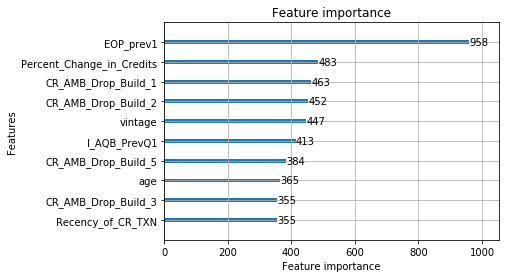

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
#plt.show()

**Explore features**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot

%matplotlib inline
#print(type(train['EOP_prev1']))
#print(type(train['EOP_prev1'][0]))
#print(train['EOP_prev1'].min)
#print(train['EOP_prev1'].max)


series=train['EOP_prev1']

#train['EOP_prev1'].hist()
#np.histogram(train['EOP_prev1'])
#count, division = np.histogram(series)
#series.hist(bins=division)
#series.value_counts(bins=60)
#series.value_counts(bins=10).plot(kind='bar')
#h=series.hist()
#h.set_xlim((1,2))
q = series.quantile(0.99)
print(q)

df=series.to_frame()
h=df.plot(kind='bar', stacked=True)

# Predict test

In [9]:
submission = pd.read_csv("../data/sample_submission.csv")

test["Responders"] = model.predict(test)
test[submission.columns].to_csv("../predictions/baseline_4.csv", index=False)

In [10]:
#test[submission.columns]